# Confidence Comparing

The idea here is that we want to compare probabilities of predicted image classes across models and the augmentations of those models. If we can say that the models are really thinking differently in terms of the probabilities they are assigning, this might have implications for understanding manipulations we can make to address the distribution gap

In [2]:
!pip install upsetplot

  Running setup.py bdist_wheel for upsetplot ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/47/6f/71/e1420187f2307bc6de0166571bd0844b2e1b180e8574ebe7d5
Successfully built upsetplot
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
from ast import literal_eval
import os
import pandas as pd
from glob import glob
import numpy as np
from sklearn.metrics import classification_report
import torchvision
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import plot 
from matplotlib import pyplot
import seaborn as sns
%matplotlib inline

In [4]:
# Retrieve the official labels of the CIFAR10 test dataset
testset = torchvision.datasets.CIFAR10(root='../../data/cifar10/', train=False,
                                       download=True)
test_labels_CIFAR10 = testset.targets
test_data_CIFAR10 = testset.data

# Retrieve the official labels of the CIFAR10.1 test dataset
test_labels_CIFAR101 =np.load('../data/cifar101/cifar10.1_v6_labels.npy')  
test_data_CIFAR101 = np.load('../data/cifar101/cifar10.1_v6_data.npy')

# Create a dictionary that maps numeric class number to class name
class_dict = {0: "airplane",
              1: "automobile",
              2: "bird",
              3: "cat",
              4: "deer",
              5: "dog",
              6: "frog",
              7: "horse",
              8: "ship",
              9: "truck"
}

classes = ['0 airplane', '1 automobile', '2 bird', '3 cat', '4  deer', '5 dog', '6 frog', 
           '7 horse', '8 ship', '9 truck']

# Confirm that when we compare these labels to our guesses, we get the accuracy score.
def confirm_score(zfile, test_labels):
    print("\nAccuracy:", zfile['acc'])
    print(" -> Sanity Check:", np.sum(test_labels_CIFAR10 == zfile['labels']), "of", 
          len(test_labels), "correct\n")
    
    # Examine the classes to see if the model is balanced in its accuracy across all labels 
    report = classification_report(test_labels, zfile['labels'], target_names=classes, output_dict=True)
    print(pd.DataFrame(report).transpose())

Extracting ../../data/cifar10/cifar-10-python.tar.gz to ../../data/cifar10/


In [5]:
number_to_analyze = 20

def error_by_r_score(zfile, test_labels, testset):
    images_to_print = []
    
    # Determine the probability we associatd with our predicted label
    pp_max = np.max(zfile['probs'], axis=1)

    # Retrieve the model's predicted probability of the correct label
    pp_correct = zfile['probs'][range(zfile['probs'].shape[0]), test_labels]

    # Calculate the R ratio for each document
    r = pp_max/pp_correct

    # Retrieve the row numbers where the R score is the highest
    max_r_value_indexes = r.argsort()

    # Create list to hold stats on highest R Score images
    stats = []
    
    for mi in max_r_value_indexes:
        #print("-- R Ratio:", r[mi], " ( index", mi, 
        #      ")\n   Guessed Label:", zfile['labels'][mi], class_dict[zfile['labels'][mi]], 
        #      "\n   Correct Label:", test_labels[mi], class_dict[test_labels[mi]],
        #      "\n   Class Probs:", zfile['probs'][mi], "\n")
        
        img_dict = {'prob_predicted': pp_max[mi],
                    'prob_correct': pp_correct[mi],
                    'r_value': r[mi],
                    'label_predicted_id': zfile['labels'][mi],
                    'label_predicted': class_dict[zfile['labels'][mi]],
                    'correct_label': test_labels[mi],
                    'correct_label_id': class_dict[test_labels[mi]],
                    'img_index': mi
                   }

        img=Image.fromarray(testset[mi])
        images_to_print.append(img)
        stats.append(img_dict)
        


#     # Print the misclassified images
#     fig = plt.figure(figsize=(16, 4))
#     grid = ImageGrid(fig, 111,  
#                      nrows_ncols=(2, 10),  
#                      axes_pad=0.1,  
#                      )

#     for ax, im in zip(grid, images_to_print):
#         # Iterating over the grid returns the Axes.
#         ax.imshow(im)
        
    return pd.DataFrame(stats)

In [6]:
output = './densenet_BC_100_12/predictions_300.npz'
npzfile = np.load(output)
confirm_score(npzfile, test_labels_CIFAR10)


Accuracy: 0.9484
 -> Sanity Check: 9484 of 10000 correct

              f1-score  precision  recall  support
0 airplane    0.953616   0.951244  0.9560   1000.0
1 automobile  0.972541   0.971087  0.9740   1000.0
2 bird        0.939502   0.955533  0.9240   1000.0
3 cat         0.891578   0.899288  0.8840   1000.0
4  deer       0.950173   0.937683  0.9630   1000.0
5 dog         0.912937   0.898354  0.9280   1000.0
6 frog        0.966000   0.966000  0.9660   1000.0
7 horse       0.973737   0.983673  0.9640   1000.0
8 ship        0.962816   0.954769  0.9710   1000.0
9 truck       0.961209   0.968528  0.9540   1000.0
micro avg     0.948400   0.948400  0.9484  10000.0
macro avg     0.948411   0.948616  0.9484  10000.0
weighted avg  0.948411   0.948616  0.9484  10000.0


In [7]:
output = './densenet_BC_100_12/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
confirm_score(npzfile101, test_labels_CIFAR101)


Accuracy: 0.883
 -> Sanity Check: 0 of 2000 correct

              f1-score  precision  recall  support
0 airplane    0.857143   0.859296   0.855    200.0
1 automobile  0.854749   0.968354   0.765    200.0
2 bird        0.883951   0.873171   0.895    200.0
3 cat         0.824742   0.851064   0.800    200.0
4  deer       0.914005   0.898551   0.930    200.0
5 dog         0.862155   0.864322   0.860    200.0
6 frog        0.928040   0.921182   0.935    200.0
7 horse       0.934673   0.939394   0.930    200.0
8 ship        0.883495   0.858491   0.910    200.0
9 truck       0.881671   0.822511   0.950    200.0
micro avg     0.883000   0.883000   0.883   2000.0
macro avg     0.882462   0.885634   0.883   2000.0
weighted avg  0.882462   0.885634   0.883   2000.0


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [8]:
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

In [10]:
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

In [56]:
def prob_histogram(errors_df, model, dataset):

    x1 = errors_df[errors_df['r_value'] == 1]['prob_predicted']
    x2 = errors_df[errors_df['r_value'] > 1]['prob_predicted']

    ax1 = sns.distplot(x1, hist = True, kde = False, bins = 10, label = "Classified Correct")
    ax2 = sns.distplot(x2, hist = True, kde = False, bins = 10, label = "Classified Incorrect")

    # get the highest value and then display it as text
    heights = []
    for p in ax1.patches:
        heights.append(p.get_height())

    ax1.text(0.935, 900, str(max(heights)), fontsize = 8)
    ax1.legend()
    # s = 0

    # for p in ax2.patches:
    #     s+= p.get_height()

    # for p in ax2.patches: 
    #     ax2.text(p.get_x() + p.get_width()/2.,
    #             p.get_height(),
    #             '{}'.format(int(p.get_height()*100/s)), 
    #             fontsize=14,
    #             color='red',
    #             ha='center',
    #             va='bottom')

    plt.title("Highest image probability (" + dataset + ") - " + model)
    plt.xlabel("Number of Observations")
    plt.ylim(0, 1000)
    plt.show()

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


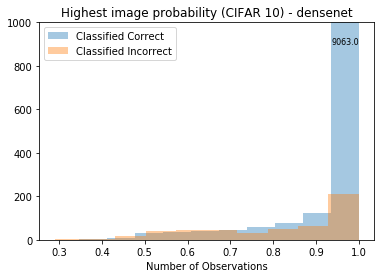

In [57]:
prob_histogram(df_densenet_errors, "densenet", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


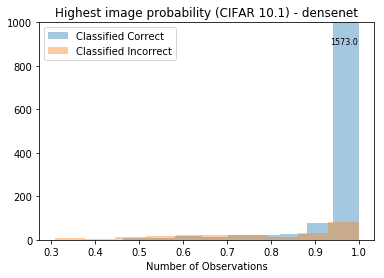

In [58]:
prob_histogram(df_densenet_errors_101, "densenet", "CIFAR 10.1")

In [60]:
# densenet ra(2,5)
output = './densenet_BC_100_12_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './densenet_BC_100_12_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


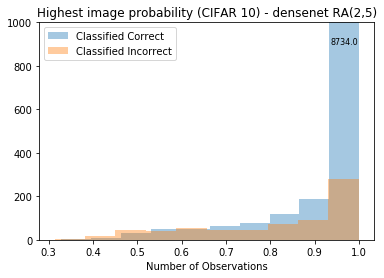

In [61]:
prob_histogram(df_densenet_errors, "densenet RA(2,5)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


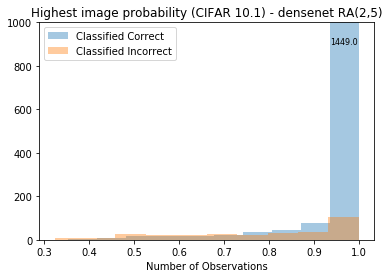

In [63]:
prob_histogram(df_densenet_errors_101, "densenet RA(2,5)", "CIFAR 10.1")

In [65]:
# densenet ra(2,20)
output = './densenet_BC_100_12_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './densenet_BC_100_12_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


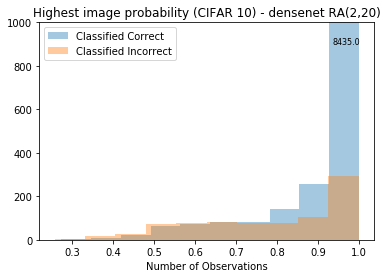

In [66]:
prob_histogram(df_densenet_errors, "densenet RA(2,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


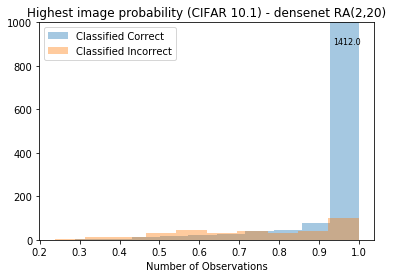

In [67]:
prob_histogram(df_densenet_errors_101, "densenet RA(2,20)", "CIFAR 10.1")

In [71]:
# densenet ra(3,20)
output = './densenet_BC_100_12_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_densenet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './densenet_BC_100_12_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_densenet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


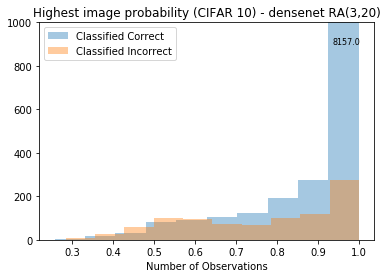

In [72]:
prob_histogram(df_densenet_errors, "densenet RA(3,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


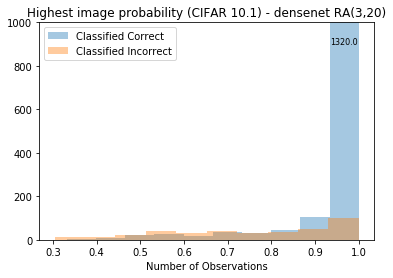

In [73]:
prob_histogram(df_densenet_errors_101, "densenet RA(3,20)", "CIFAR 10.1")

### resnet

In [76]:
# resnet basic
output = './resnet_basic_32/predictions_160.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnet_basic_32/predictions_160_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


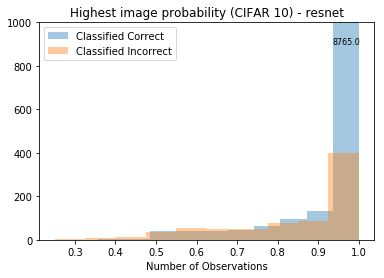

In [77]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


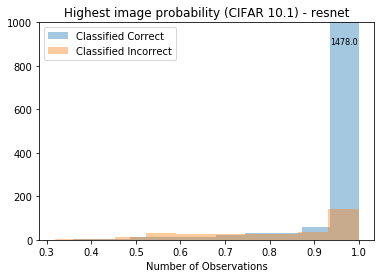

In [78]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet", "CIFAR 10.1")

In [79]:
# resnet RA(2,5)
output = './resnet_basic_32_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnet_basic_32_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


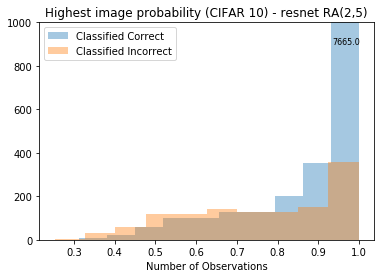

In [80]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(2,5)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


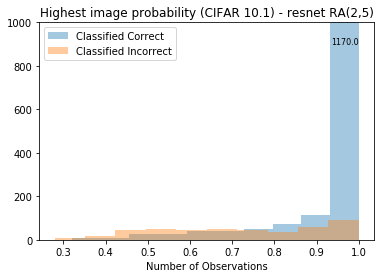

In [81]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(2,5)", "CIFAR 10.1")

In [82]:
# resnet RA(2,20)
output = './resnet_basic_32_ra_2_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnet_basic_32_ra_2_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


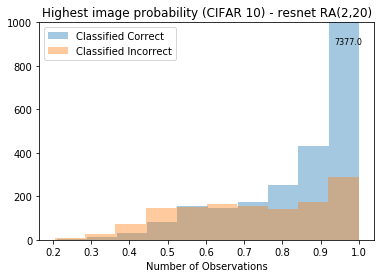

In [83]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(2,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


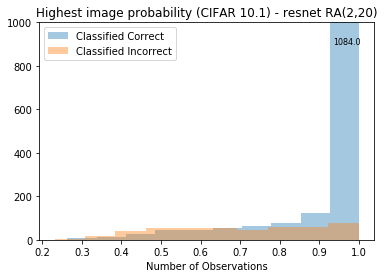

In [84]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(2,20)", "CIFAR 10.1")

In [85]:
# resnet RA(3,20)

output = './resnet_basic_32_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnet_basic_32_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


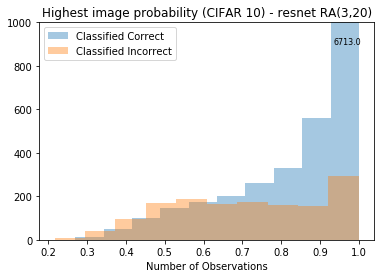

In [86]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnet RA(3,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


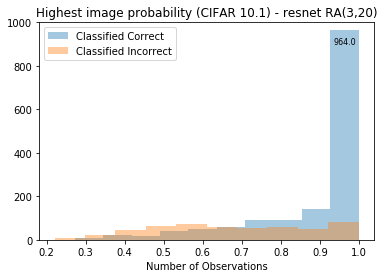

In [87]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnet RA(3,20)", "CIFAR 10.1")

### resnext

In [88]:
# resnext basic
output = './resnext_29_4x64/predictions_300.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnext_29_4x64/predictions_300_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


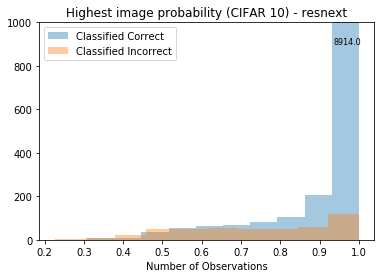

In [89]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


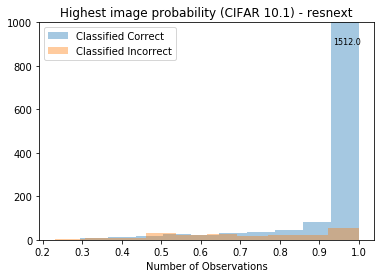

In [90]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext", "CIFAR 10.1")

In [91]:
# resnext ra(2,5)
output = './resnext_29_4x64d_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnext_29_4x64d_ra_2_5/predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


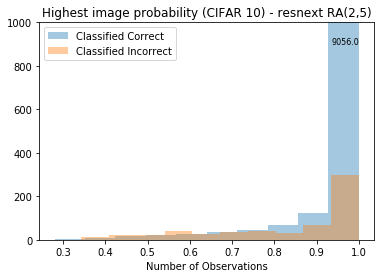

In [92]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(2,5)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


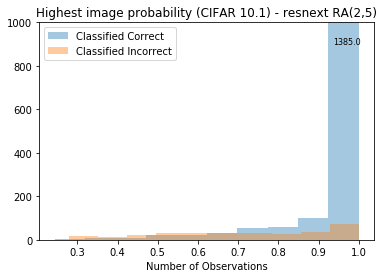

In [93]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(2,5)", "CIFAR 10.1")

In [95]:
# resnext ra(2,20)
# w210-capstone/original_model_results/resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz
output = './resnext_29_4x64_ra_2_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnext_29_4x64_ra_2_20/ predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


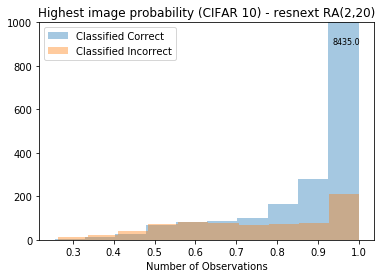

In [96]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(2,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


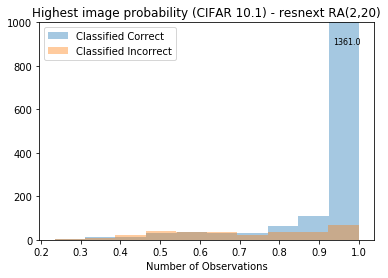

In [97]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(2,20)", "CIFAR 10.1")

In [99]:
# resnext ra(3,20)
output = './resnext_29_4x64_ra_3_20/ predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './resnext_29_4x64_ra_3_20/ predictions_400_refined50_cifar101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


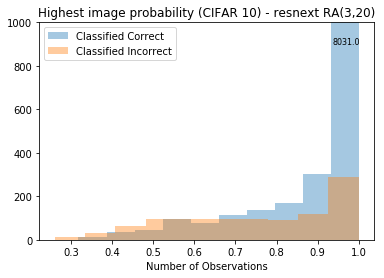

In [100]:
# plot cifar10
prob_histogram(df_resnet_errors, "resnext RA(3,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


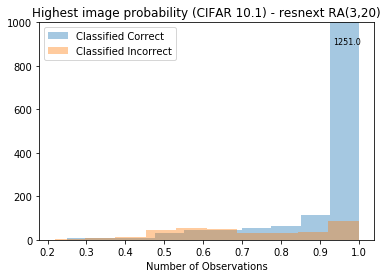

In [101]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "resnext RA(3,20)", "CIFAR 10.1")

### wrn

In [102]:
# wrn basic
output = './wrn_28_10/predictions_200.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './wrn_28_10/predictions_200_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


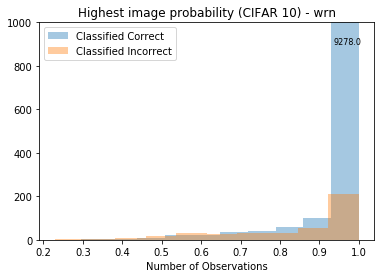

In [103]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


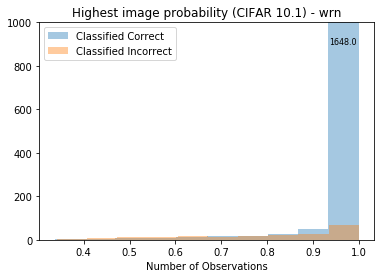

In [104]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn", "CIFAR 10.1")

In [105]:
# wrn ra(2,5)
output = './wrn_28_10_ra_2_5/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './wrn_28_10_ra_2_5/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


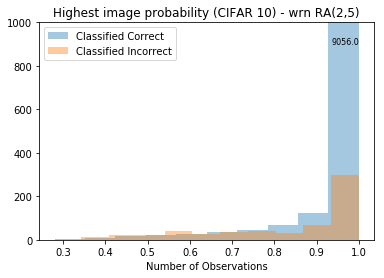

In [106]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(2,5)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


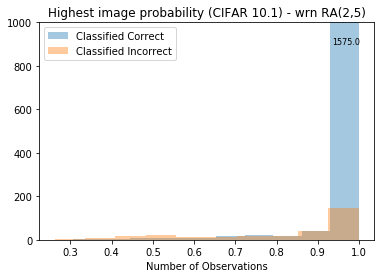

In [107]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(2,5)", "CIFAR 10.1")

In [109]:
# wrn ra(2,20)
output = './wrn_28_10_ra_2_20/predictions_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './wrn_28_10_ra_2_20/predictions_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


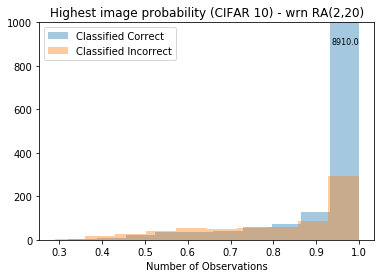

In [110]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(2,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


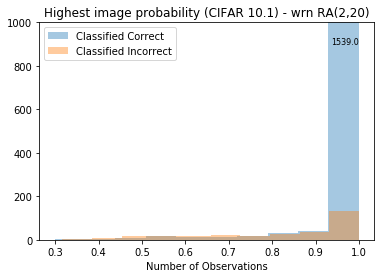

In [111]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(2,20)", "CIFAR 10.1")

In [112]:
# wrn ra(3,20)
output = './wrn_28_10_ra_3_20/predictions_400_refined50.npz'
npzfile = np.load(output)
df_resnet_errors  = error_by_r_score(npzfile, test_labels_CIFAR10, test_data_CIFAR10)

output = './wrn_28_10_ra_3_20/predictions_400_refined50_CIFAR101.npz'
npzfile101 = np.load(output)
df_resnet_errors_101  = error_by_r_score(npzfile101, test_labels_CIFAR101, test_data_CIFAR101)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


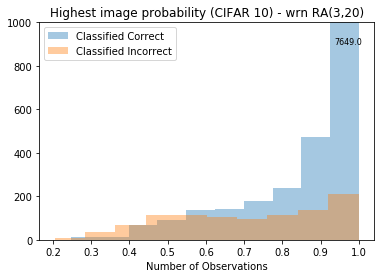

In [113]:
# plot cifar10
prob_histogram(df_resnet_errors, "wrn RA(3,20)", "CIFAR 10")

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


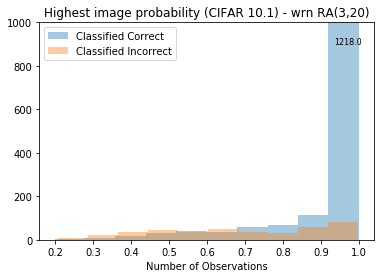

In [114]:
# plot cifar101
prob_histogram(df_resnet_errors_101, "wrn RA(3,20)", "CIFAR 10.1")